<a href="https://colab.research.google.com/github/SwethaSrikari/Predicting-EV-charging-demand/blob/main/Data_collection%2Bcleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An attempt at recreating [Performance Comparison of Deep Learning Approaches in Predicting EV Charging Demand](https://www.mdpi.com/2071-1050/15/5/4258#B43-sustainability-15-04258) 


The dataset includes [Boulder-Colorado Electric Vehicle Charging Station Energy Consumption](https://open-data.bouldercolorado.gov/datasets/39288b03f8d54b39848a2df9f1c5fca2_0/explore) downloaded from the website and [Boulder-Colarado weather](https://psl.noaa.gov/boulder/data.daily.html) data collected using web scraping

This notebook has cells that collect the data, clean the data and merge the data to be further processed for training

**Instructions - Run all these cells consecutively to get the final merged dataset**



In [ ]:
# Import necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

# Scraping  Boulder-Colarado weather data from the NOAA/NWS Cooperative Site

In [ ]:
url = 'https://psl.noaa.gov/boulder/data.daily.html'
response = requests.get(url)
print(response.status_code)

# Turning raw HTML to formatted or parsed data
soup = BeautifulSoup(response.text, 'html.parser')

200


**[Scarping tables from html page](https://colab.research.google.com/drive/1PLwGLPRO1ha0Nk4GGXiz4YprWqug9COw)**

If there are multiple tables and you don't know the table number of the table you want to find - 
1. Right click on the page and Select `Inspect`
2. A page with html code appears. Select `Console` that appears on top of that page.
3. Paste this is in the console - 

`var i = 1; [].forEach.call(document.querySelectorAll('table'), 
function(x) { console.log(i++, x); });`
4. It gives you a list of tables and their numbers.
5. If you place your cursor on a table in the `Console` Tab, the corresponding table in the html page will be highlighted
6. You can search for the table number this way

Reference - https://youtu.be/i_nse8KdCkk

In [ ]:
# the table numbers were found using the above mentioned method - 
tables_year = {'2018': [num for num in range(195, 218, 2)],
               '2019': [num for num in range(219, 242, 2)],
               '2020': [num for num in range(243, 266, 2)],
               '2021': [num for num in range(267, 290, 2)],
               '2022': [num for num in range(291, 314, 2)],
               '2023': [num for num in range(315, 320, 2)]}

Tables from a HTML page to pandas Dataframe - https://towardsdatascience.com/a-guide-to-scraping-html-tables-with-pandas-and-beautifulsoup-7fc24c331cf7

In [ ]:
def weather_year(year):
  """
  Scrapes data from https://psl.noaa.gov/boulder/data.daily.html
  Returns a weather dataframe for the specified year (includes all months in the year)

  :param year: The year you want to scrape data from (str)

  Returns a dataframe 
  """

  rows = []
  for table in tables_year[year]:
    for i, child in enumerate(soup.find_all('table')[table].children):
      row = []
      for td in child:
        try:
          row.append(td.text)
        except:
          continue
      if len(row) > 0:
        rows.append(row)
  
  return pd.DataFrame(rows[1:], columns=rows[0]).drop_duplicates(keep=False) # drops duplicate rows

Cleaning weather data 

1. Check column names and rename them if there are extra spaces

2. *T is a trace (less than .01 inches for precipitation and .1 for snow)* - From website. Replace those values respectively

3. Change Year, Month and Day to numeric

4. Missing values

Check for missing values even when `dataframe.info()` says no null values.
One way to do it is by checking unique values in each column using `value_counts()`
In the weather dataset, the values for Feb 29 on a non-leap year are labelled `Miss`. So remove the rows with Feb 29 on a non-leap year

5. Check the data type of columns and convert datatypes to appropriate datatype

6. Create a Date column by merging Year, Month and Day 

7. Use Date column to merge weather data with the EV consumption data

In [ ]:
# # Check values in each column
# for c in df_2018.columns:
#   print(c, df_2018[c].value_counts().index)

In [ ]:
def clean_data(dataframe, not_leap=True):

  # Change column names to remove spaces
  dataframe.columns = ['Year', 'Month', 'Day', 'Maximum T', 'Minimum T', 'Precipitation',
        'Snow', 'Snow Depth']

  # "T" is a trace (less than .01 inches for precipitation and .1 for snow)
  dataframe["Snow"] = dataframe["Snow"].replace('   T ', 0.099)
  dataframe["Precipitation"] = dataframe["Precipitation"].replace('   T ', 0.0099)

  # Change year, month, day to numeric
  dataframe[["Year", "Month", "Day"]] = dataframe[["Year", "Month", "Day"]].apply(pd.to_numeric)
  # Drop Feb 29 in a year that is not a leap year
  if not_leap:
    dataframe = dataframe.drop(dataframe[(dataframe["Month"] == 2) & (dataframe["Day"] == 29)].index)

  # Change columns from objects to numeric and remove Snow Depth column
  dataframe = dataframe[["Year", "Month", "Day", "Maximum T", "Minimum T", "Precipitation", "Snow"]].apply(pd.to_numeric)

  # Create date column
  dataframe["Date"] = pd.to_datetime(dataframe[["Year", "Month", "Day"]]).dt.date

  return dataframe

2018 Boulder colorado weather

In [ ]:
df_2018 = weather_year('2018')
df_2018 = clean_data(df_2018)
df_2018

,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow,Date
0,2018,1,1,30,12,0.0000,0.000,2018-01-01
1,2018,1,2,46,12,0.0000,0.000,2018-01-02
2,2018,1,3,50,20,0.0000,0.000,2018-01-03
3,2018,1,4,52,24,0.0000,0.000,2018-01-04
4,2018,1,5,62,25,0.0000,0.000,2018-01-05
...,...,...,...,...,...,...,...,...
372,2018,12,27,34,18,0.0099,0.099,2018-12-27
373,2018,12,28,23,13,0.0099,0.099,2018-12-28
374,2018,12,29,37,5,0.0099,0.099,2018-12-29
375,2018,12,30,50,21,0.0000,0.000,2018-12-30


In [ ]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 376
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           365 non-null    int64  
 1   Month          365 non-null    int64  
 2   Day            365 non-null    int64  
 3   Maximum T      365 non-null    int64  
 4   Minimum T      365 non-null    int64  
 5   Precipitation  365 non-null    float64
 6   Snow           365 non-null    float64
 7   Date           365 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 25.7+ KB


2019 Boulder Colorado weather

In [ ]:
df_2019 = weather_year('2019')
df_2019 = clean_data(df_2019)
df_2019

,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow,Date
0,2019,1,1,13,2,0.03,0.6,2019-01-01
1,2019,1,2,41,1,0.00,0.0,2019-01-02
2,2019,1,3,56,22,0.00,0.0,2019-01-03
3,2019,1,4,61,17,0.00,0.0,2019-01-04
4,2019,1,5,60,32,0.00,0.0,2019-01-05
...,...,...,...,...,...,...,...,...
372,2019,12,27,36,18,0.00,0.0,2019-12-27
373,2019,12,28,30,22,0.16,2.7,2019-12-28
374,2019,12,29,36,14,0.00,0.0,2019-12-29
375,2019,12,30,36,11,0.00,0.0,2019-12-30


In [ ]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 376
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           365 non-null    int64  
 1   Month          365 non-null    int64  
 2   Day            365 non-null    int64  
 3   Maximum T      365 non-null    int64  
 4   Minimum T      365 non-null    int64  
 5   Precipitation  365 non-null    float64
 6   Snow           365 non-null    float64
 7   Date           365 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 25.7+ KB


2020 Boulder Colorado weather

In [ ]:
df_2020 = weather_year('2020')
df_2020 = clean_data(df_2020, not_leap=False)
df_2020

,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow,Date
0,2020,1,1,53,23,0.00,0.0,2020-01-01
1,2020,1,2,48,28,0.00,0.0,2020-01-02
2,2020,1,3,47,23,0.00,0.0,2020-01-03
3,2020,1,4,65,28,0.00,0.0,2020-01-04
4,2020,1,5,58,28,0.00,0.0,2020-01-05
...,...,...,...,...,...,...,...,...
372,2020,12,27,50,34,0.00,0.0,2020-12-27
373,2020,12,28,37,26,0.03,0.5,2020-12-28
374,2020,12,29,36,19,0.07,0.6,2020-12-29
375,2020,12,30,41,13,0.00,0.0,2020-12-30


2021 Boulder Colorado weather

In [ ]:
df_2021 = weather_year('2021')
df_2021 = clean_data(df_2021)
df_2021

,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow,Date
0,2021,1,1,43,22,0.00,0.0,2021-01-01
1,2021,1,2,52,17,0.00,0.0,2021-01-02
2,2021,1,3,53,31,0.00,0.0,2021-01-03
3,2021,1,4,59,30,0.00,0.0,2021-01-04
4,2021,1,5,55,29,0.00,0.0,2021-01-05
...,...,...,...,...,...,...,...,...
372,2021,12,27,44,21,0.00,0.0,2021-12-27
373,2021,12,28,37,23,0.00,0.0,2021-12-28
374,2021,12,29,33,10,0.00,0.0,2021-12-29
375,2021,12,30,44,16,0.00,0.0,2021-12-30


2022 Boulder Colorado weather

In [ ]:
df_2022 = weather_year('2022')
df_2022 = clean_data(df_2022)
df_2022

,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow,Date
0,2022,1,1,25,5,0.4300,7.1,2022-01-01
1,2022,1,2,50,-4,0.0000,0.0,2022-01-02
2,2022,1,3,51,22,0.0000,0.0,2022-01-03
3,2022,1,4,49,30,0.0000,0.0,2022-01-04
4,2022,1,5,36,11,0.1700,2.6,2022-01-05
...,...,...,...,...,...,...,...,...
372,2022,12,27,62,32,0.0000,0.0,2022-12-27
373,2022,12,28,57,41,0.0099,0.0,2022-12-28
374,2022,12,29,41,21,1.2600,9.3,2022-12-29
375,2022,12,30,37,19,0.0000,0.0,2022-12-30


2023 Boulder Colorado weather

In [ ]:
df_2023 = weather_year('2023')
df_2023 = clean_data(df_2023)
df_2023

,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow,Date
0,2023,1,1,40,28,0.0000,0.0,2023-01-01
1,2023,1,2,31,26,0.1100,0.9,2023-01-02
2,2023,1,3,26,16,0.0600,0.7,2023-01-03
3,2023,1,4,37,13,0.0000,0.0,2023-01-04
4,2023,1,5,38,13,0.0000,0.0,2023-01-05
...,...,...,...,...,...,...,...,...
88,2023,3,27,35,23,0.1800,2.6,2023-03-27
89,2023,3,28,48,14,0.0000,0.0,2023-03-28
90,2023,3,29,49,26,0.0000,0.0,2023-03-29
91,2023,3,30,65,25,0.0099,0.0,2023-03-30


#  Boulder-Colorado Electric Vehicle Charging Station Energy Consumption data 2018-2023




Download the Data as a csv file to your local folder or drive from - https://open-data.bouldercolorado.gov/datasets/39288b03f8d54b39848a2df9f1c5fca2_0/explore

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/EV_stations_demand/Electric_Vehicle_Charging_Station_Energy_Consumption.csv')
# Set the datetime columns
df[['Start_Date___Time', 'End_Date___Time']] = df[['Start_Date___Time', 'End_Date___Time']].apply(pd.to_datetime)
# Create a date column without timestamp
df["Date"] = df['Start_Date___Time'].dt.date

Mounted at /content/drive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57891 entries, 0 to 57890
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   Station_Name                57891 non-null  object             
 1   Address                     57891 non-null  object             
 2   City                        57891 non-null  object             
 3   State_Province              57891 non-null  object             
 4   Zip_Postal_Code             57891 non-null  int64              
 5   Start_Date___Time           57891 non-null  datetime64[ns, UTC]
 6   Start_Time_Zone             57891 non-null  object             
 7   End_Date___Time             57889 non-null  datetime64[ns, UTC]
 8   End_Time_Zone               57891 non-null  object             
 9   Total_Duration__hh_mm_ss_   57891 non-null  object             
 10  Charging_Time__hh_mm_ss_    57891 non-null  object        

# Merge weather dataframes with EV Energy consumption dataframe and clean the dataframe

In [ ]:
# Concat all weather dataframes into one dataframe

weather_df = pd.concat([df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)

In [ ]:
df = df.merge(weather_df, on='Date', how='left')
df

,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,...,Port_Type,ObjectId,Date,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow
0,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018-01-20 07:29:00+00:00,MDT,2018-01-20 09:22:00+00:00,MDT,1:52:59,...,Level 2,1,2018-01-20,2018,1,20,62,31,0.00,0.0
1,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018-02-09 16:57:00+00:00,MDT,2018-02-09 19:06:00+00:00,MDT,2:08:58,...,Level 2,2,2018-02-09,2018,2,9,56,24,0.00,0.0
2,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,2018-01-01 17:49:00+00:00,MDT,2018-01-01 19:52:00+00:00,MDT,2:03:02,...,Level 2,3,2018-01-01,2018,1,1,30,12,0.00,0.0
3,BOULDER / REC CENTER ST2,1360 Gillaspie Dr,Boulder,Colorado,80305,2018-01-25 18:58:00+00:00,MDT,2018-01-25 19:00:00+00:00,MDT,0:02:00,...,Level 2,4,2018-01-25,2018,1,25,53,28,0.00,0.0
4,BOULDER / FACILITIES ST1,1745 14th street,Boulder,Colorado,80302,2018-02-05 17:01:00+00:00,MDT,2018-02-06 11:38:00+00:00,MDT,18:36:59,...,Level 2,5,2018-02-05,2018,2,5,53,20,0.02,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57886,BOULDER / BASELINE ST1,600 Baseline Rd,Boulder,Colorado,80302,2023-03-31 02:46:00+00:00,MDT,2023-03-31 04:15:00+00:00,MDT,1:29:04,...,Level 2,57887,2023-03-31,2023,3,31,51,33,0.00,0.0
57887,BOULDER / CARPENTER PARK1,1505 30th St,Boulder,Colorado,80303,2023-03-31 03:57:00+00:00,MDT,2023-03-31 10:53:00+00:00,MDT,6:55:49,...,Level 2,57888,2023-03-31,2023,3,31,51,33,0.00,0.0
57888,BOULDER / BASELINE ST1,600 Baseline Rd,Boulder,Colorado,80302,2023-03-31 04:49:00+00:00,MDT,2023-03-31 07:38:00+00:00,MDT,2:49:18,...,Level 2,57889,2023-03-31,2023,3,31,51,33,0.00,0.0
57889,BOULDER / N BOULDER REC 1,3172 Broadway,Boulder,Colorado,80304,2023-03-31 06:46:00+00:00,MDT,2023-03-31 07:35:00+00:00,MDT,0:48:12,...,Level 2,57890,2023-03-31,2023,3,31,51,33,0.00,0.0


Clean merged dataframe for training

From the paper - 
 

*   The total dataset contained 43,659 charging sessions.
*   For each session, the following information was considered: station ID and location, connection port, start and end times, connection durations, charging durations, kWh consumed, greenhouse gas reductions and gasoline savings, and unique driver identification.
*   The snow and precipitation was input in millimeters. 
*   Change month feature from numbers to names
*   Remove null (0) values in Engery_kwh_








In [ ]:
df.head(5)

,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,...,Port_Type,ObjectId,Date,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow
0,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018-01-20 07:29:00+00:00,MDT,2018-01-20 09:22:00+00:00,MDT,1:52:59,...,Level 2,1,2018-01-20,2018,1,20,62,31,0.00,0.0
1,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018-02-09 16:57:00+00:00,MDT,2018-02-09 19:06:00+00:00,MDT,2:08:58,...,Level 2,2,2018-02-09,2018,2,9,56,24,0.00,0.0
2,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,2018-01-01 17:49:00+00:00,MDT,2018-01-01 19:52:00+00:00,MDT,2:03:02,...,Level 2,3,2018-01-01,2018,1,1,30,12,0.00,0.0
3,BOULDER / REC CENTER ST2,1360 Gillaspie Dr,Boulder,Colorado,80305,2018-01-25 18:58:00+00:00,MDT,2018-01-25 19:00:00+00:00,MDT,0:02:00,...,Level 2,4,2018-01-25,2018,1,25,53,28,0.00,0.0
4,BOULDER / FACILITIES ST1,1745 14th street,Boulder,Colorado,80302,2018-02-05 17:01:00+00:00,MDT,2018-02-06 11:38:00+00:00,MDT,18:36:59,...,Level 2,5,2018-02-05,2018,2,5,53,20,0.02,0.0


In [ ]:
# Inches to millimeters
df['Snow'] = df['Snow'] * 25.4
df['Precipitation'] = df['Precipitation'] * 25.4

# Extract day of the week for weekly dataset
df['Day_of_the_week'] = pd.to_datetime(df['Date']).dt.day_name()

# Change month feature from numbers to names
df['Month'] = pd.to_datetime(df['Date']).dt.month_name()

# Change datatype from float to integer
df[["Year", "Day"]] = df[["Year", "Day"]].astype(np.int64)
df 

,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,...,ObjectId,Date,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow,Day_of_the_week
0,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018-01-20 07:29:00+00:00,MDT,2018-01-20 09:22:00+00:00,MDT,1:52:59,...,1,2018-01-20,2018,January,20,62,31,0.000,0.0,Saturday
1,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018-02-09 16:57:00+00:00,MDT,2018-02-09 19:06:00+00:00,MDT,2:08:58,...,2,2018-02-09,2018,February,9,56,24,0.000,0.0,Friday
2,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,2018-01-01 17:49:00+00:00,MDT,2018-01-01 19:52:00+00:00,MDT,2:03:02,...,3,2018-01-01,2018,January,1,30,12,0.000,0.0,Monday
3,BOULDER / REC CENTER ST2,1360 Gillaspie Dr,Boulder,Colorado,80305,2018-01-25 18:58:00+00:00,MDT,2018-01-25 19:00:00+00:00,MDT,0:02:00,...,4,2018-01-25,2018,January,25,53,28,0.000,0.0,Thursday
4,BOULDER / FACILITIES ST1,1745 14th street,Boulder,Colorado,80302,2018-02-05 17:01:00+00:00,MDT,2018-02-06 11:38:00+00:00,MDT,18:36:59,...,5,2018-02-05,2018,February,5,53,20,0.508,0.0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57886,BOULDER / BASELINE ST1,600 Baseline Rd,Boulder,Colorado,80302,2023-03-31 02:46:00+00:00,MDT,2023-03-31 04:15:00+00:00,MDT,1:29:04,...,57887,2023-03-31,2023,March,31,51,33,0.000,0.0,Friday
57887,BOULDER / CARPENTER PARK1,1505 30th St,Boulder,Colorado,80303,2023-03-31 03:57:00+00:00,MDT,2023-03-31 10:53:00+00:00,MDT,6:55:49,...,57888,2023-03-31,2023,March,31,51,33,0.000,0.0,Friday
57888,BOULDER / BASELINE ST1,600 Baseline Rd,Boulder,Colorado,80302,2023-03-31 04:49:00+00:00,MDT,2023-03-31 07:38:00+00:00,MDT,2:49:18,...,57889,2023-03-31,2023,March,31,51,33,0.000,0.0,Friday
57889,BOULDER / N BOULDER REC 1,3172 Broadway,Boulder,Colorado,80304,2023-03-31 06:46:00+00:00,MDT,2023-03-31 07:35:00+00:00,MDT,0:48:12,...,57890,2023-03-31,2023,March,31,51,33,0.000,0.0,Friday


In [ ]:
# Check 'Energy_kWh_' column for null values
# df['Energy__kWh_'].value_counts()

# Remove null (0) values in Engery_kwh_
df = df[df['Energy__kWh_'] != 0]

In [ ]:
df

,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,...,ObjectId,Date,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow,Day_of_the_week
0,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018-01-20 07:29:00+00:00,MDT,2018-01-20 09:22:00+00:00,MDT,1:52:59,...,1,2018-01-20,2018,January,20,62,31,0.000,0.0,Saturday
1,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018-02-09 16:57:00+00:00,MDT,2018-02-09 19:06:00+00:00,MDT,2:08:58,...,2,2018-02-09,2018,February,9,56,24,0.000,0.0,Friday
2,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,2018-01-01 17:49:00+00:00,MDT,2018-01-01 19:52:00+00:00,MDT,2:03:02,...,3,2018-01-01,2018,January,1,30,12,0.000,0.0,Monday
4,BOULDER / FACILITIES ST1,1745 14th street,Boulder,Colorado,80302,2018-02-05 17:01:00+00:00,MDT,2018-02-06 11:38:00+00:00,MDT,18:36:59,...,5,2018-02-05,2018,February,5,53,20,0.508,0.0,Monday
5,BOULDER / ATRIUM ST1,1770 13th St,Boulder,Colorado,80302,2018-01-31 08:45:00+00:00,MDT,2018-01-31 11:04:00+00:00,MDT,2:18:39,...,6,2018-01-31,2018,January,31,59,24,0.000,0.0,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57886,BOULDER / BASELINE ST1,600 Baseline Rd,Boulder,Colorado,80302,2023-03-31 02:46:00+00:00,MDT,2023-03-31 04:15:00+00:00,MDT,1:29:04,...,57887,2023-03-31,2023,March,31,51,33,0.000,0.0,Friday
57887,BOULDER / CARPENTER PARK1,1505 30th St,Boulder,Colorado,80303,2023-03-31 03:57:00+00:00,MDT,2023-03-31 10:53:00+00:00,MDT,6:55:49,...,57888,2023-03-31,2023,March,31,51,33,0.000,0.0,Friday
57888,BOULDER / BASELINE ST1,600 Baseline Rd,Boulder,Colorado,80302,2023-03-31 04:49:00+00:00,MDT,2023-03-31 07:38:00+00:00,MDT,2:49:18,...,57889,2023-03-31,2023,March,31,51,33,0.000,0.0,Friday
57889,BOULDER / N BOULDER REC 1,3172 Broadway,Boulder,Colorado,80304,2023-03-31 06:46:00+00:00,MDT,2023-03-31 07:35:00+00:00,MDT,0:48:12,...,57890,2023-03-31,2023,March,31,51,33,0.000,0.0,Friday


# Pickle the merged weather and EV energy consumption dataset for training - to avoid repeating all these steps every time before training

In [ ]:
# Pickle dataset
df.to_csv('/content/drive/MyDrive/EV_stations_demand/weather_ev.csv')

# Another notebook - Prepare data for training + data analysis
Paper used data from January 2018 to August 2022
df = df[pd.to_datetime(df['Date']) < pd.to_datetime('2022-08-01')]

<BarContainer object of 12 artists>

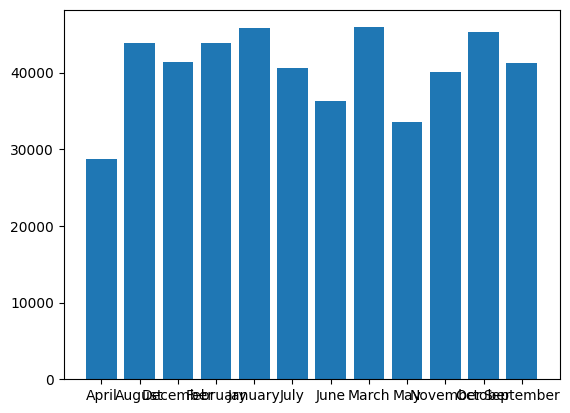

In [ ]:
# Bar plot of average EV charging load consumption per month.

import matplotlib.pyplot as plt

monthly_average_energy = df.groupby('Month', as_index=False)['Energy__kWh_'].sum()
plt.bar(monthly_average_energy['Month'], monthly_average_energy['Energy__kWh_'])

In [ ]:
# Table 3 matches
df['Energy__kWh_'].describe()

count    39813.000000
mean         8.907981
std          7.984857
min          0.001000
25%          3.819000
50%          6.801000
75%         11.631000
max         85.200000
Name: Energy__kWh_, dtype: float64